# 7장 딥러닝을 위한 고급 도구

[케라스 창시자에게 배우는 딥러닝] 책을 기반으로 제가 정리하고 요약한 내용입니다.  
주말 푹 쉬고 왔습니다. 책 1회독이 얼마 안남았으니 힘내봅시다!

## 7.1 Sequential 모델을 넘어서: 케라스의 함수형 API

지금까지는 이 책의 모든 신경망을 Sequential 모델을 사용했습니다. Sequential 모델은 네트워크 입력과 출력이 하나라고 가정합니다.

하지만 이런 가정이 맞지 않는 경우도 많습니다. 일부 네트워크는 개별 입력이 여러 개 필요하거나 출력이 여러 개 필요합니다. 층을 차례대로 쌓지 않고 층 사이를 연결하여 그래프처럼 만드는 네트워크도 있습니다.

여러 경우에 다중 입력 모델, 다중 출력 모델, 그래프 구조를 딘 모델이 필요하지만 케라스의 Sequential 클래스를 사용해서는 만들지 못합니다. 케라스에는 훨씬 더 일반적이고 유연한 방법인 **함수형 API**가 있습니다.

### 7.1.1 함수형 API 소개

**함수형 API**에서는 직접 텐서들의 입출력을 다룹니다. 함수처럼 층을 사용하여 텐서를 입력받고 출력합니다.

간단한 예를 통해 Sequential 모델과 함수형 API 모델을 비교하겠습니다.

In [0]:
from keras.models import Sequential, Model
from keras import layers
from keras import Input

# Sequential
seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

# 함수형 API
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

Model 객체를 사용한 컴파일, 훈련 평가 API는 Sequential 클래스와 같습니다.

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_entropy')

import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 64))

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train)

### 7.1.2 다중 입력 모델

함수형 API는 다중 입력 모델을 만드는 데 사용할 수 있습니다. 일반적으로 이런 모델은 입력 가지를 합치기 위해 여러 텐서를 연결할 수 있는 층을 사용합니다.

질문-응답 모델을 예시로 사용해보겠습니다. 전형적인 질문-응답 모델은 2개의 입력을 가집니다. 하나는 자연어 질문이고, 또 하나는 답변에 필요한 정보가 담겨 있는 텍스트입니다. 간단한 구조는 미리 정의한 어휘 사전에서 소프트맥스 함수를 통해 한 단어로 된 답을 출력하는 것입니다.

In [0]:
# 코드 7-1 2개의 입력을 가진 질문-응답 모델의 함수형 API 구현하기

from keras.models import Model
from keras import layers
from keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 텍스트 입력은 길이가 정해지지 않은 정수 시퀀스입니다.
# 입력 이름은 지정할 수 있습니다.
text_input = Input(shape=(None, ), dtype='int32', name='text')
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)

# 질문도 동일한 변환을 취합니다.
question_input = Input(shape=(None, ), dtype='int32', name='question')
embedded_question = layers.Embedding(question_vocabulary_size, 64)(question_input)
encoded_question = layers.LSTM(32)(embedded_question)

# 연결합니다.
concatenated = layers.concatenate([encoded_text, encoded_question])

# softmax 분류기를 추가합니다.
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

# 모델 객체를 만들고 2개의 입력과 출력을 주입합니다.
model = Model([text_input, question_input], answer)
model.complie(optimizer='rmsprop',loss='categorical_crossentropy',metricss=['acc'])

이렇게 입력이 2개인 모델은 2가지 방식으로 훈련할 수 있습니다.
1. 넘파이 배열의 리스트를 주입
2. 입력 이름과 넘파이 배열로 이루어진 딕셔너리를 모델의 입력으로 주입(입력 이름을 설정햇을 때 사용 가능)

In [0]:
# 코드 7-2 다중 입력 모델에 데이터 주입하기
import numpy as np
from keras.utils import to_categorical

num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))

answers = np.random.randomint(0, answer_vocabulary_size, size=num_samples)
answers = to_categorical(answers) # 원핫 인코딩

# 1.리스트 입력 사용
model.fit([text, question], answers, epochs=10, batch_size=128)
# 2. 딕셔너리 입력을 사용하여 학습
model.fit({'text':text, 'question':question}, answers, epochs=10, batch_size=128)

### 7.1.3 다중 출력 모델

다중 출력 모델을 만들 수 있습니다. 예를 들어 소셜 미디어에서 익명 사용자의 포스트를 입력으로 받아 그 사람의 나이, 성별, 소득 수준 등일 예측합니다.

In [0]:
# 코드 7-3 3개의 출력을 가진 함수형 API 구현하기

from keras import layers
from keras import Input
from keras.models import Model

vocabulary_size = 50000
num_income_groups = 10

post_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size,256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 출력 층에 이름 붙이기
age_prediction  = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model= = Model(post_input, [age_prediction, income_prediction, gender_prediction])

이런 모델을 훈련하려면 네트워크 출력마다 다른 손실 함수를 지정해야 합니다. 경사 하강법은 하나의 스칼라 값을 최소화하기 때문에 모델을 훈련하려면 이 손실들을 하나의 값으로 합쳐야 합니다. 손실 값을 합치는 가장 간단한 방법은 모두 더하는 것입니다. 케라스에서는 ```compile``` 메서드에서 리스트나 딕셔너리를 사용하여 출력마다 다른 손실을 지정할 수 있습니다. 계산된 손실 값은 전체 손실 하나로 더해지고 훈련 과정에서 최소화됩니다.

In [0]:
# 코드 7-4 다중 출력 모델의 컴파일 옵션: 다중 손실

# 1. 리스트로 손실함수 지정
model.compile(optimizer='rmsprop', 
              loss=['mse','categorical_crossentropy', 'binary_crossentroypy'])

# 2. 딕셔너리로 손실함수 지정
model.compile(optimizer='rmsprop', 
              loss={'age':'mse', 'income':'categorical_crossentropy', 'gender':'binary_crossentroypy'})

그러나 손실 값이 많이 불균형하면 모델이 개별 손실이 가장 큰 작업에 치우쳐 표현을 최적화 하므로 다른 작업들은 손해를 입습니다. 이를 해결하기 위해 손실 값이 최종 손실에 기여하는 수준을 지정할 수 있습니다. 특히 손실 값의 스케일이 다를 때 유용합니다.

In [0]:
# 코드 7-5 다중 출력 모델의 컴파일 옵션: 손실 가중치
# 1. 리스트로 손실함수 지정 + 가중치
model.compile(optimizer='rmsprop', 
              loss=['mse','categorical_crossentropy', 'binary_crossentroypy'], 
              loss_weights=[0.25, 1., 10.])

# 2. 딕셔너리로 손실함수 지정 + 가중치
model.compile(optimizer='rmsprop', 
              loss={'age':'mse', 'income':'categorical_crossentropy', 'gender':'binary_crossentroypy'}, 
              loss_weights={'age':0.25, 'income':1., 'gender':10.})

다중 입력 모델과 마찬가지로 넘파이 배열의 리스트나 딕셔너리를 모델에 전달하여 훈련합니다.

In [0]:
# 코드 7-6 다중 출력 모델에 데이터 주입하기

# 1. 리스트
model.fit(posts, [age_targets, income_targets, gender_targets], 
          epochs=10, batch_size=64)

# 2. 딕셔너리
model.fit(posts, {'age' : age_targets, 'incomde' : income_targets, 'gender' : gender_targets}, 
          epochs=10, batch_size=64)

### 7.1.4 층으로 구성된 비순환 유향 그래프

함수형 API를 사용하면 앞선 모델뿐만 아니라 내부 토폴로지가 복잡한 네트워크도 만들 수 있습니다. 케라스의 신경망은 층으로 구성된 어떤 **비순환 유향 그래프(directed acyclic graph)** 도 만들 수 있습니다.

그래프로 구현된 몇 개의 신경망 컴포넌트가 널리 사용됩니다. 가장 유명한 2개가 앞서 언급한 인셉션 모듈과 잔차 연결입니다.

**인셉션 모듈**

**인셉션(Inception)** 은 합성곱 신경망에서 인기 있는 네트워크 구조입니다. 나란히 분기된 가지를 따라 모듈을 쌓아 독립된 작은 네트워크처럼 구성합니다.  
가장 기본적인 인셉션 모듈 형태는 3~4개의 가지를 가집니다. 1x1 합성곱으로 시작해서 3x3 합성곱이 뒤따르고 마지막에 전체 출력 특성이 합쳐집니다. 이런 구성은 네트워크가 따로따로 공간 특성과 채널 방향의 특성을 학습하도록 돕습니다.

다음은 **인셉션 V3(Inception V3)** 에 있는 모듈의 예입니다.

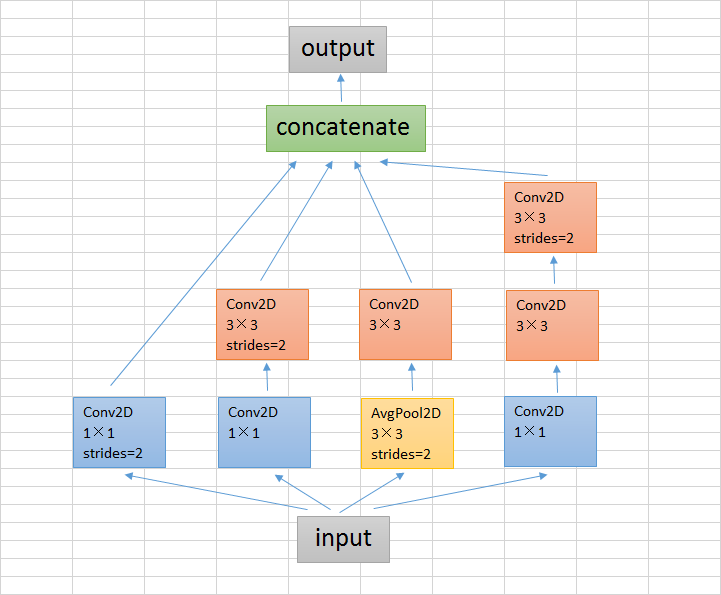

In [0]:
from IPython.display import Image
 
Image("inceptionv3.png")

이 예에서는 입력 x는 4D 텐서라고 가정합니다.

In [0]:
from keras import layers

# 모든 가지는 동일한 스트라이드(2)를 사용합니다. 출력 크기를 동일하게 만들어 하나로 합치기 위해서입니다.
branch_a = layers.Conv2D(128, 1, activation='relu', strides=2)(x)

# 이 가지에서는 두 번째 합성곱 층에서 스트라이드를 적용합니다.
branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

# 이 가지에서는 평균 풀링 층에서 스트라이드를 적용합니다.
branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 3, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_d)
# 모든 가지의 출력을 연결하여 모듈의 출력을 만듭니다.
output = layers.concatenate([branceh_a, branch_b, branch_c, branch_d], axis=-1)

인셉션 V3 전체 구조는 케라스의 ```keras.applications.inception_v3.InceptionV3```에 준비되어 있으며, ImageNet 데이터셋에서 사전 훈련된 가중치를 포함하고 있습니다.  이와 비슷한 **엑셉션(Xception)** 모델도 케라스에 포함되어 있습니다. 이 합성곱 구조는 채널 방향의 학습과 공간 방향의 학습을 극단적으로 분리한다는 아이디어에 착안하여 인셉션 모듈을 깊이별 분리 합성곱으로 바꿉니다. 이 합성곱은 깊이별 합성곱 다음에 점별 합성곱이 뒤따릅니다. 인셉션 모듈의 극한 형태로 공간 특성과 채널 방향 특성을 완전히 분리합니다. 엑셉션은 인셉션V3와 거의 동일한 개수의 모델 파라미터를 가지지만 실행 속도가 더 빠르고 대규모 데이터셋에서 정확도가 더 높습니다. 이는 모델 파라미터를 더 효율적으로 사용하기 때문입니다.

**잔차 연결**

**잔차 연결(residual connection)** 은 엑셉션을 포함하여 2015년 이후 등장한 많은 네트워크 구조에 있는 그래프 형태의 네트워크 컴포넌트입니다. 대규모 딥러닝 모델에서 흔히 나타나는 두 가지 문제인 그래디언트 소실과 표현 병목(representational bottleneck)을 해결했습니다. 일반적으로 10개 층 이상을 가진 모델에 잔차 연결을 추가하면 도움이 됩니다.

잔차 연결은 하위 층의 출력을 상위 층의 입력으로 사용합니다. 순서대로 놓인 네트워크를 질러가는 연결이 만들어집니다. 하위 층의 출력이 상위 층의 출력에 연결되는 것이 아니라 더해집니다. 따라서 두 출력의 크기가 동일해야 합니다. 크기가 다르면 선형 변환을 사용하여 하위 층의 활성화 출력을 목표 크기로 변환합니다.

이 예는 케라스에서 특성 맵의 크기가 같을 때 원본을 그대로 사용하는 잔차 연결을 구현한 것이고, 입력 x가 4D 텐서라고 가정합니다.

In [0]:
from keras import layers

x = ...
# x에 어떤 변환을 적용합니다.
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# 원본 x를 출력 특성에 더합니다.
y = layers.add([y, x])

다음은 특성 맵의 크기가 다를 때 선형 변환을 사용하여 잔차 연결을 구현한 예입니다.(x = 4D 텐서)

In [0]:
from keras import layers

x = ...
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# y와 크기를 맞추기 위해 1x1 합성곱을 사용하여 원본 텐서 x를 다운샘플링합니다.
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

# 다운샘플링된 x를 출력 특성에 더합니다.
y = layers.add([y, residual])

### 7.1.5 층 가중치 공유

함수형 API의 중요한 또 하나의 기능은 층 객체를 여러 번 재사용할 수 있다는 것입니다. 층 객체를 두 번 호출하면 새로운 객체를 만들지 않고 각 호출에 동일한 가중치를 재사용합니다. 이런 기능 때문에 공유 가지를 가진 모델을 만들 수 있습니다.

예를 들어 두 문장 사이의 의미가 비슷한지 측정하는 모델입니다. 이 모델은 2개의 입력(비교할 2개의 문장)을 받고 0(관련 없는 문장)과 1(두 문장이 동일하거나 재구성되었다는 것) 사이의 점수를 출력합니다. 

이런 문제에서는 의미가 비슷하다는 것은 대칭적인 관계이기 때문에 두 입력 시퀀스가 바뀔 수 있습니다. A에서 B에 대한 유사도는 B에서 A에 대한 유사도와 같습니다. 이런 이유 때문에 각 입력 ㅁ누장을 처리하는 2개의 독립된 모델을 학습하지 않고 하나의 LSTM 층으로 양쪽을 모두 처리하는 것이 좋습니다. 이를 **샴 LSTM(Siamese LSTM)** 모델 또는 **공유 LSTM** 이라고 부릅니다.

In [0]:
from keras import layers
from keras import Input
from keras.models import Model

# LSTM 층 객체 하나를 만듭니다.
lstm = layers.LSTM(32)

# 모델의 왼쪽 가지를 구성합니다. 입력은 크기가 128인 벡터의 가변 길이 시퀀스입니다.
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

# 모델의 오른쪽 가지를 구성합니다. 기존 층 객체를 호출하면 가중치가 재사용됩니다.
right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

# 맨 위에 분류기를 놓습니다.
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# 모델  객체를 만들고 훈련합니다. 이런 모델을 훈련하면 LSTM 층의 가중치는 양쪽 입력을 바탕으로 업데이트 됩니다.
model = Model([left_input, right_input], predictions)
model.fit([left_data, right_data], targets) 

### 7.1.6 층과 모델

함수형 API에서는 모델을 층처럼 사용할 수 있습니다. ```Sequential``` 클래스와 ```Model``` 클래스에서 모두 동일합니다. 이 말은 입력 텐서로 모델을 호출해서 출력 텐서를 얻을 수 있다는 뜻입니다.


In [0]:
from keras import layers
from keras import applications
from keras import Input

# 이미지 처리 기본 모델은 엑셉션 네트워크입니다.(합성곱 기반 층만 사용합니다)
xception_base = applications.Xception(weights=None, include_top=False)

# 입력은 250x250 RGB 이미지입니다.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

# 같은 비전 모델을 두 번 호출합니다.
left_features = xception_base(left_input)
right_features = xception_base(right_input)

# 합쳐진 특성은 오른쪽 입력과 왼쪽 입력에서 얻은 정보를 담고 있습니다.
merged_features = layers.concatenete([left_features, right_features], axis=-1)

### 7.1.7 정리

* 함수형 API를 사용하여 다중 입력, 다중 출력, 복잡한 네트워크 토폴로지를 갖는 케라스 모델을 만드는 방법
* 다른 네트워크 가지에서 같은 층이나 모델 객체를 여러 번 호출하여 가중치를 재사용하는 방법

## 7.2 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

여기서는 훈련하는 동안 모델 내부에서 일어나는 일을 조사하고 제어하는 방법을 알아봅니다.

### 7.2.1 콜백을 사용하여 모델 훈련 과정 제어하기

지금까지 예제는 적절한 훈련 에포크를 알아내기 위해 첫 번째 실행에서 오버피팅이 시작될 때까지 충분한 에포크로 훈련한 다음 최적의 에포크 횟수로 처음부터 새로운 훈련을 시작했습니다. 당연히 이런 방식은 낭비가 많습니다.

더 좋은 방법은 검증 손실을 관측하여 더 이상 향상되지 않는 지점에서 훈련을 멈추는 것입니다. 이를 케라스의 콜백을 이용해서 구현할 수 있습니다. **콜백(callback)** 은 모델의 ```fit()``` 메서드가 호출된 때 전달되는 객체입니다. 훈련하는 동안 모델은 여러 지점에서 콜백을 호출합니다. 콜백은 모델의 상태와 성능에 대한 모든 정보에 접근하고 훈련 중지, 모델 저장, 가중치 적재 또는 모델 상태 변경 등을 처리할 수 있습니다. 다음의 사례들에서 사용할 수 있습니다.

* **모델 체크포인트 저장** : 훈련하는 동안 어떤 지점에서 모델의 현재 가중치를 저장합니다.
* **조기 종료** : 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지합니다.
* **훈련하는 동안 하이퍼파라미터 값을 동적으로 조정합니다** : 옵티마이저의 학습률 같은 경우입니다.
* **훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화합니다** : 앞서 보았던 케라스의 진행 표시줄이 하나의 콜백입니다.

In [0]:
# keras.callbacks 모듈은 많은 내장 콜백을 포함합니다.
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger

이 예들을 살펴봅시다.

**ModelCheckpoint와 EarlyStopping 콜백**

```EarlyStopping``` 콜백을 사용하면 정해진 에포크 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지할 수 있습니다. 예를 들면 오버피팅이 시작되자마자 훈련을 중지할 수 있습니다. 일반적으로 이 콜백은 훈련하는 동안 모델을 계속 저장해주는 ```ModelCheckpoint```와 함께 사용합니다. (지금까지 가장 좋은 모델만 저장가능)

In [0]:
import keras

# fit() 메서드의 callbacks 매개변수를 사용하여 콜백의 리스트를 모델로 전달합니다. 몇 개의 콜백이라도 전달할 수 있습니다.
callback_list = [
    # 성능 향상이 멈추면 훈련을 중지합니다.  
    keras.callbacks.EarlyStopping(
        monitor='val_acc', # 모델의 검증 정확도를 모니터링합니다.
        patience=1, # 1 에포크보다 더 길게 정확도가 향상되지 않으면 훈련이 중지됩니다.
    ),
    # 에포크마다 현재 가중치를 저장합니다.  
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5', # 모델 파일의 경로
        monitor='val_loss', # 이 두 매개변수는 val_loss가 좋아지지 않으면 모델 파일을 덮어쓰지 않겠다는 뜻입니다.
        save_best_only=True,# 훈련하는 동안 가장 좋은 모델이 저장됩니다.
    )
]

model.compile(optimizer='rmsprop',
              loss='binary_crossentroypy',
              metrics['acc']) # 정확도를 모니터링하므로 모델 지표에 포함되어야 합니다.

# 콜백이 검증 손실과 검증 정확도를 모니터링하기 때문에 validation_data 매개변수에 검증 데이터를 전달해야 합니다.
model.fit(x,y, 
          epochs=10, 
          batch_size=32, 
          callbacks=callback_list, 
          validation_data=(x_val, y_val))

**ReduceLROnPlateau 콜백**

이 콜백을 사용하면 검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있습니다. 손실 곡선이 평탄할 때 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최솟값에서 효과적으로 빠져나올 수 있습니다.

In [0]:
callback_list = [
    keras.callbacks.ReduceLRONPlateau(
        monitor='val_acc', # 모델의 검증 손실을 모니터링합니다.
        factor=0.1, # 콜백이 호출될 때 학습률을 10배로 줄입니다.
        patience=10, # 검증 손실이 10 에포크 동안 좋아지지 않으면 콜백이 호출됩니다.
    )
]

**자신만의 콜백 만들기**

내장 콜백에서 제공하지 않는 경우 필요에 따라 콜백을 만들 수 있습니다. 콜백은 ```keras.callbacks.Callback``` 클래스를 상속받아 구현합니다. 그다음 훈련하는 동안 호출될 여러 지점을 나타내기 위해 약속된 다음 메서드를 구현합니다.

on_epoch_begin --- 각 에포크가 시작할 때 호출합니다.  
on_epoch_end --- 각 에포크가 끝날 때 호출합니다.  
on_batch_begin --- 각 배치 처리가 시작되기 전에 호출합니다.  
on_batch_end --- 각 배치 처리가 끝난 후에 호출합니다.  
on_train_begin --- 훈련이 시작될 때 호출합니다.  
on_train_end --- 훈련이 끝날 때 호출합니다.  

이 메서드들은 모두 log 매개변수와 함께 호출됩니다. 이 매개변수에는 이전 배치, 에포크에 대한 훈련과 검증 측정값이 담겨 있는 딕셔너리가 전달됩니다. 콜백은 다음 속성을 참조할 수 있습니다.
* self.model: 콜백을 호출하는 모델 객체
* self.validation_data: fit() 메서드에 전달된 검증 데이터

다음은 매 에포크의 끝에서 검증 세트의 첫 번째 샘플로 모델에 있는 모든 층의 활성화 출력을 계산하여 디스크에 저장하는 자작 콜백의 예입니다.

In [0]:
from keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback): 
    # 호출하는 모델에 대한 정보를 전달하기 위해 훈련하기 전에 호출됩니다.
    def set_model(self, model):
        self.model = model
        layer_output = [layer.output for layer in model.layers ]
        self.activation_model = keras.models.Model(model.input, 
                                                   layer_outputs) # 각 층의 활성화 출력을 반환하는 Model 객체입니다.

    def on_epoch_end(self, epoch, log=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
            
        validation_sample = self.validation_data[0][0:1] # 검증 데이터의 첫 번째 샘플을 가져옵니다.
        activation = self.activations_model.predict(validation_sample)
        # 배열을 디스크에 저장합니다.
        f = open('activaions_at_epoch_' + str(epoch) + '.npz', 'wb')
        np.savez(f, activations)
        f.close()

### 7.2.2 텐서보드 소개: 텐서플로의 시각화 프레임워크

좋은 연구를 하거나 좋은 모델을 개발하려면 실험하는 모델 내부에서 어떤 일이 일어나는지 자주 그리고 많은 피드백을 받아야 합니다. 이 절에서는 텐서플로와 함께 제공되는 브라우저 기반 시각화 도구인 텐서보드를 소개합니다. 텐서플로 백엔드로 케라스를 설정한 경우에만 케라스 모델에서 사용할 수 있습니다.

텐서보드의 핵심 목적은 훈련 모델의 내부에서 일어나는 모든 것을 시각적으로 모니터링할 수 있도록 돕는 것입니다. 모델의 최종 손실 외에 더 많은 정보를 모니터링하면 모델 작동에 대한 명확한 그림을 그릴 수 있고, 개선을 빠르게 할 수 있습니다. 텐서보드는 여러 가지 멋진 기능을 제공합니다.

* 훈련하는 동안 측정 지표를 시각적으로 모니터링합니다.
* 모델 구조를 시각화합니다.
* 활성화 출력과 그래디언트의 히스토그램을 그립니다.
* 3D로 임베딩을 표현합니다.

기능들을 사용하기 위해 IMDB 감성 분석 문제를 1D 컨브넷으로 훈련하겠습니다. 빈도가 높은 2,000개 단어만 사용하겠습니다.

In [0]:
# 코드 7-7 텐서보드를 사용한 텍스트 분류 모델
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128, 
                           input_length=max_len, 
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=['acc'])

텐서보드를 시작하기 전에 로그 파일이 저장될 디렉터리를 만들어야 합니다.

In [0]:
# 코드 7-8 텐서보드 로그 파일을 위한 디렉터리 생성하기
!mkdir my_log_dir

TensorBoard 콜백 객체와 함께 훈련을 시작합니다. 이 콜백은 지정된 디스크 위치에 로그 이벤트를 기록할 것입니다.

In [0]:
# 코드 7-9 텐서보드 콜백과 함께 모델 훈련하기
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='my_log_dir', # 로그 파일이 기록될 위치입니다.
        histogram_freq=1, # 1 에포크마다 활성화 출력의 히스토그램을 기록합니다.
        embeddings_freq=1, # 1 에포크마다 임베딩 데이터를 기록합니다.
    )
]
hitory = model.fit(x_train, y_train, 
                   epochs=20,
                   batch_size=128, 
                   validation_split=0.2,
                   callbacks=callbacks)

여기서 embeddings_data 매개변수의 에러로 실행을 못했습니다. 스택오버플로우에서 찾아봤는데 원하는 결과를 못찾아서 일단 코드이해로 넘어갑니다.


이제 명령행에서 콜백이 사용하는 로그 디렉터리를 지정하여 텐서보드 서버를 실행합니다. 텐서플로 설치시에 텐서보드 유틸리티는 자동으로 설치됩니다.

In [0]:
tensorboard --logdir=my_log_dir

### 7.2.3 정리

* 케라스 콜백은 훈련하는 동안 모델을 모니터링하고  모델 상태를 바탕으로 자동으로 작업을 수행하는 손쉬운 방법입니다.
* 텐서보드를 이용하여 모델 상황을 브라우저에서 시각화할 수 있습니다.

## 7.3 모델의 성능을 최대로 끌어올리기

### 7.3.1 고급 구조 패턴

잔차 연결 외에 꼭 알아야 할 디자인 패턴이 2개 더 있습니다. 정규화와 깊이별 분리 합성곱입니다. 특히 고성능 심층 컨브넷을 만들 때 유용합니다.

**배치 정규화**

**정규화(normalization)** 는 머신 러닝 모델에 주입되는 샘플들을 균일하게 만드는 광범위한 방법입니다. 이 방법은 모델이 학습하고 새로운 데이터에 잘 일반화되도록 돕습니다. 이미 전에 여러번 나왔습니다. 데이터에서 평균을 빼서 데이터를 원점에 맞추고 표준 편차로 나누어 데이터의 분산을 1로 만듭니다.

In [0]:
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)

이전 예제에는 모델에 데이터를 주입하기 전에 정규화했습니다. 하지만 데이터 정규화는 네트워크에서 일어나는 모든 변환 후에도 고려되어야 합니다. Dense나 Conv2D 층에 들어가는 데이터의 평균이 0이고 분산이 1이라도 출력되는 데이터가 동일한 분포를 가질 것이라고 기대하기는 어렵습니다.

**배치 정규화**는 2015년에 아이오페와 세게디가 제안한 층의 한 종류입니다. 케라스는 ```BatchNormalization``` 클래스로 제공합니다. 훈련한는 동안 평균과 분산이 바뀌더라도 이에 적응하여 데이터를 정규화합니다. 훈련 과정에서 사용된 배치 데이터의 평균과 분산에 대한 지수 이동 평균을 내부에 유지합니다.

배치 정규화의 주요 효과는 잔차 연결과 매우 흡사하게 그래디언트의 전파를 도와주는 것입니다. (입력과 출력의 분포가 유지) 결국 더 깊은 네트워크를 구성할 수 있습니다. ResNet50, 인셉션 V3, 엑셉션 등이 있습니다. 다음은 사용하는 예시입니다.

In [0]:
# Conv2D 층 다음에
conv_model.add(layers.Conv2D(32, 3 activation='relu'))
conv_model.add(layers.BatchNormalization())

# Dense 층 다음에
dense_model.add(layers.Dense(32, activation='relu'))
dense_model.add(layers.BatchNormalization())

BatchNormalization 클래스에는 정규화할 특성 축을 지정하는 axis 매개변수가 있습니다. 이 매개변수의 기본값은 입력 텐서의 마지막 축을 나타내는 -1 입니다. (data_format을 "chanels_last"인 경우에 해당, "chanels_first"인 경우는 매개변수를 1로 설정)

**깊이별 분리 합성곱**

Conv2D를 대체하면서 더 가볍고 더 빨라 모델의 성능을 높일 수 있는 층이 있습니다. **깊이별 분리 합성곱(depthwise separable convolution)** 층은 입력 채널별로 따로따로 공간 방향의 합성곱을 수행합니다. (SeparableConv2D으로 사용합니다.) 그다음 점별 합성곱을 통해 출력 채널을 합칩니다. 이는 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과를 냅니다. 모델 파라미터와 연산의 수를 크게 줄여 주기 때문에 작고 더 빠른 모델을 만듭니다.

제한된 데이터로 작은 모델을 처음부터 훈련시킬 때 특히 더 중요합니다. 작은 데이터셋에서 이미지 분류 문제를 위한 가벼운 깊이별 분리 컨브넷을 만드는 예입니다.

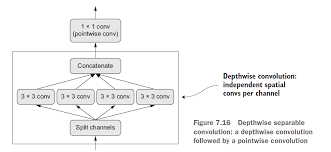

In [6]:

from IPython.display import Image
 
Image("separableconv2d.png")

In [0]:
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height. width, channels,)))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layer.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

### 7.3.2 하이퍼파라미터 최적화

딥러닝 모델은 무작위 선택의 연속입니다. 층의 수, 유닛과 필터 수, 활성화 함수의 종류 등 설계자의 이유있는 랜덤한 선택의 연속입니다. 이런 구조에 관련된 파라미터를 역전파로 훈련되는 모델 파라미터와 구분하여 **하이퍼파라미터(hyperparameter)** 라고 합니다.

하이퍼파라미터 튜닝에 공식적인 규칙은 없습니다. 직관은 있을 수 있으나 정해를 찾을 수는 없습니다. 그렇다고 하이퍼파라미터 튜닝을 모두 사람이 하고 있을 수는 없기에 이것도 기계의 힘을 빌립니다. 가능한 결정 공간을 자동적, 조직적, 규칙적 방법으로 탐색해야합니다. 전형적인 최적화 과정은 다음과 같습니다.
1. 일련의 하이퍼파라미터를 (자동으로) 선택합니다.
2. 선택된 하이퍼파라미터로 모델을 만듭니다.
3. 훈련 데이터에 학습하고 검증 데이터에서 최종 성능을 측정합니다.
4. 다음으로 시도할 하이퍼파라미터를 (자동으로) 선택합니다.
5. 이 과정을 반복합니다.
6. 마지막으로 테스트 데이터에서 성능을 측정합니다.

주어진 하이퍼파라미터에서 얻은 검증 성능을 사용하여 다음 번에 시도할 하이퍼파라미터를 선택하는 알고리즘이 핵심입니다. 베이지안 최적화, 유전 알고리즘, 간단한 랜덤 탐색 등 여러가지 기법을 사용할 수 있습니다.

### 7.3.3 모델 앙상블

**모델 앙상블(model ensemble)** 은 여러 개 다른 모델의 예측을 합쳐서 더 좋은 예측을 만듭니다. 캐글 같은 머신 러닝 경연 대회에서는 우승자들이 대규모 모델 앙상블을 사용합니다.

분류 예를 들어보면 분류기 예측을 앙상블하기 위해 합치는 가장 쉬운 방법은 추론할 때 나온 예측을 평균 내는 것입니다.

In [0]:
# 4개의 다른 모델을 사용하여 초기 예측을 계산합니다.
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

# 새로운 예측은 어떤 초기 예측보다 더 정확해야 합니다.
final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)

이 방식은 분류기들이 어느 정도 비슷하게 좋을 때 잘 작동합니다.

분류기를 앙상블하는 좋은 방법은 검증 데이터에서 학습된 가중치를 사용하여 가중 평균하는 것입니다. 전형적으로 분류기가 좋을수록 높은 가중치를 가지고 나쁜 분류기일수록 낮은 가중치를 갖습니다.

In [0]:
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

# 가중치 (0.5, 0.25, 0.1, 0.15)는 경험적으로 학습되었다고 가정합니다.
final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d

이외에도 여러 가지 변종이 있는데 예를 들어 예측의 지수 값을 평균할 수 있습니다. 일반적으로 검증 데이터에서 찾은 최적의 가중치로 단순하게 가중 평균하는 방법이 좋은 기본값입니다.

앙상블이 잘 작동하게 만드는 핵심은 분류기의 다양성입니다. 모델이 서로 다른 방향으로 편향되어 있다면 편향은 서로 상쇄되고 앙상블이 더 정확해질 것입니다.

모든 문제에 적용하지 못하지만 실전에서 잘 작동하는 한 가지 방법은 트리 기반 모델(랜덤 포레스트나 그래디언트 부스팅 트리)이나 심층 신경망을 앙상블하는 것입니다. 최근에 실전에서 매우 성공적으로 사용되는 기본 앙상블 스타일은 딥러닝과 얕은 모델을 섞은 넓고 깊은 모델입니다. 이런 모델은 심층 신경망과 많은 선형 모델을 함께 훈련합니다. 다양한 종류의 모델들을 함께 훈련하는 것은 모델 앙상블을 만드는 또 다른 방법입니다.

### 7.3.4 정리

* 고성능 심층 컨브넷을 만들려면 잔차 연결, 배치 정규화, 깊이별 분리 합성곱을 사용해야 합니다.
* 심층 네트워크를 만들 때 많은 하이퍼파라미터와 네트워크 구조를 선택해야 합니다.
* 가장 좋은 앙상블은 가능한 서로 다른 모델로 만드는 것입니다.

## 7.4 요약
* 임의의 층 그래프를 구성하는 방법, 층을 재사용하는 방법(가중치 공유), 파이썬 함수 방식으로 모델을 사용하는 방법
* 케라스 콜백
* 텐서보드
* 배치 정규화, 깊이별 분리 합성곱, 잔차 연결
* 하이퍼파라미터 최적화, 모델 앙상블